<a href="https://colab.research.google.com/github/hckasd/p/blob/main/doanchuyendechuyensau2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs


Cloning into 'german-traffic-signs'...
Receiving objects: 100% (6/6), 117.80 MiB | 2.53 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import random
import pickle
import pandas as pd
import cv2
from keras.models import load_model


In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "Số lượng hình ảnh không bằng số lượng nhãn"
assert(X_val.shape[0] == y_val.shape[0]), "Số lượng hình ảnh không bằng số lượng nhãn"
assert(X_test.shape[0] == y_test.shape[0]), "Số lượng hình ảnh không bằng số lượng nhãn"
assert(X_train.shape[1:] == (32,32,3)), "Kích thước của hình ảnh không phải là 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "Kích thước của hình ảnh không phải là 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "Kích thước của hình ảnh không phải là 32 x 32 x 3"

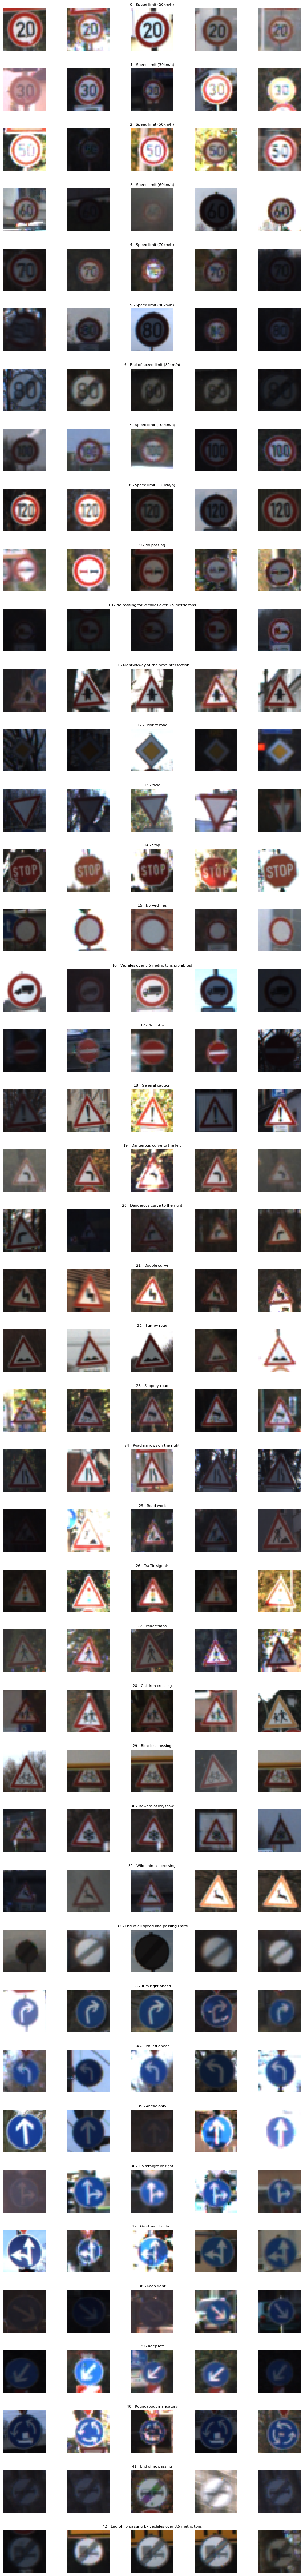

In [ ]:
# Đọc tên các biển báo
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
# Tạo lưới subplot
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(10, 80))
fig.tight_layout(pad=1.0)
# Duyệt qua từng lớp
for j in range(num_classes):
    x_selected = X_train[y_train == j]

    # Kiểm tra nếu không có mẫu nào thì bỏ qua
    if len(x_selected) == 0:
        continue
    num_of_samples.append(len(x_selected))
    for i in range(cols):
        random_index = random.randint(0, len(x_selected) - 1)
        axs[j][i].imshow(x_selected[random_index], cmap='gray')
        axs[j][i].axis("off")
        # Thêm tên biển báo ở cột giữa
        if i == 2:
            axs[j][i].set_title(f"{j} - {data['SignName'][j]}", fontsize=8)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


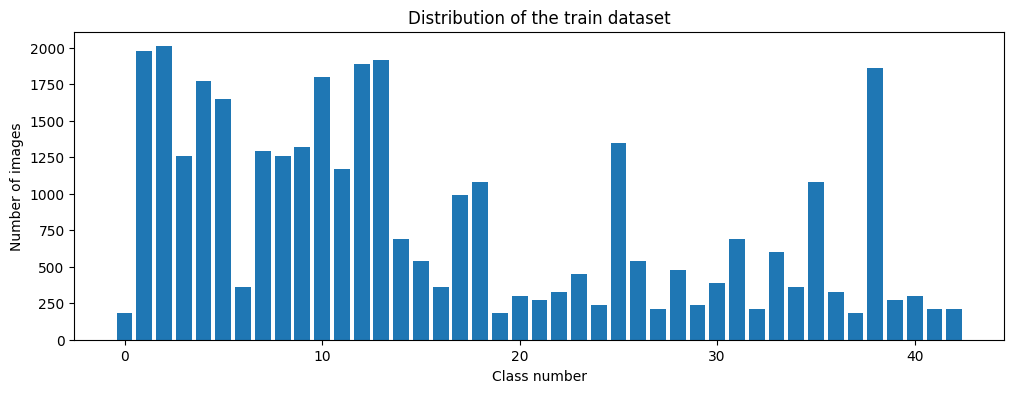

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


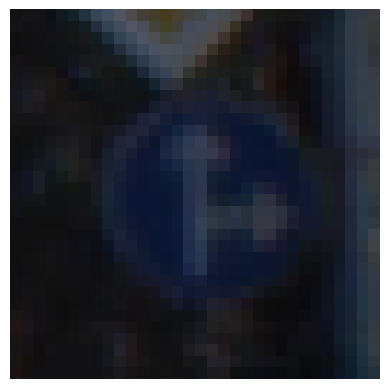

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


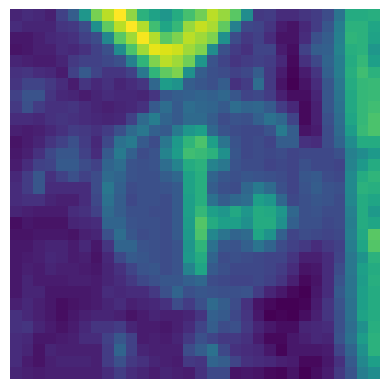

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


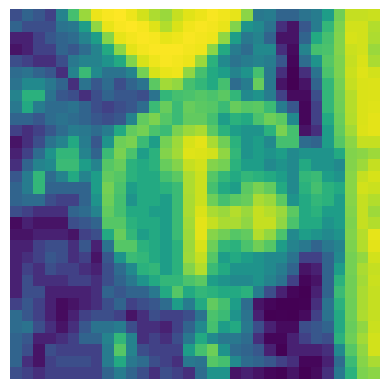

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(34799, 32, 32, 1)


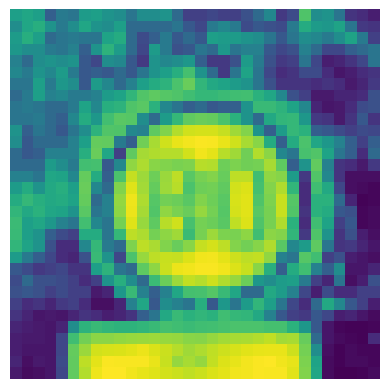

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

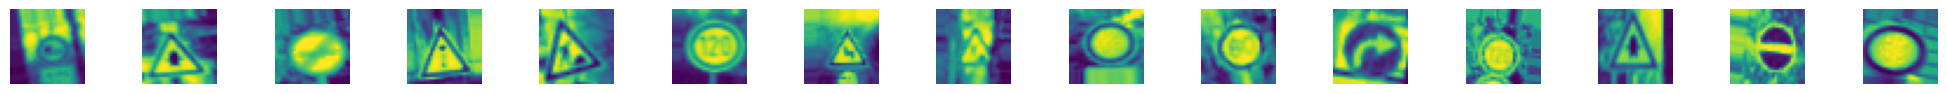

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')


In [ ]:
print(X_batch.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

(20, 32, 32, 1)
(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60,(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  #Compile model
  model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = leNet_model()
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
 history = model.fit(datagen.flow(X_train, y_train, batch_size=100), epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.2384 - loss: 2.8173 - val_accuracy: 0.8791 - val_loss: 0.4087
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7597 - loss: 0.7934 - val_accuracy: 0.9385 - val_loss: 0.1863
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8619 - loss: 0.4434 - val_accuracy: 0.9753 - val_loss: 0.0839
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9045 - loss: 0.3099 - val_accuracy: 0.9669 - val_loss: 0.1059
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9251 - loss: 0.2423 - val_accuracy: 0.9830 - val_loss: 0.0591
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9395 - loss: 0.1973 - val_accuracy: 0.9893 - val_loss: 0.0438
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9458 - loss: 0.1757 - val_accuracy: 0.9855 - val_loss: 0.0529
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9523 - loss: 0.1560 - 

Text(0.5, 0, 'epoch')

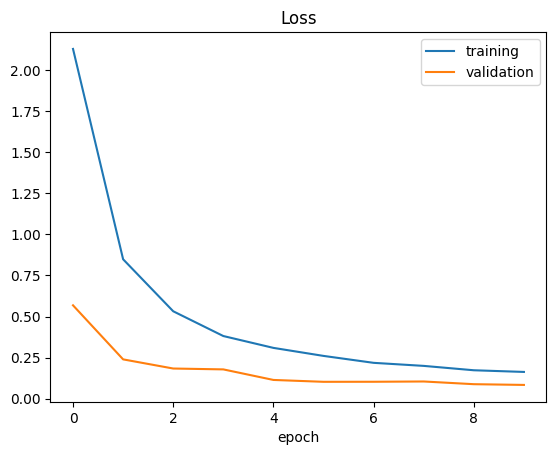

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

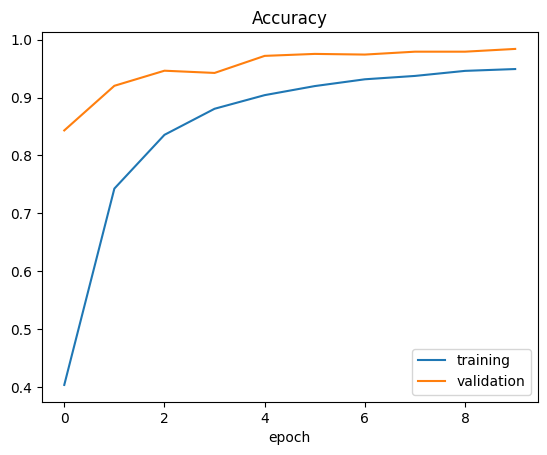

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


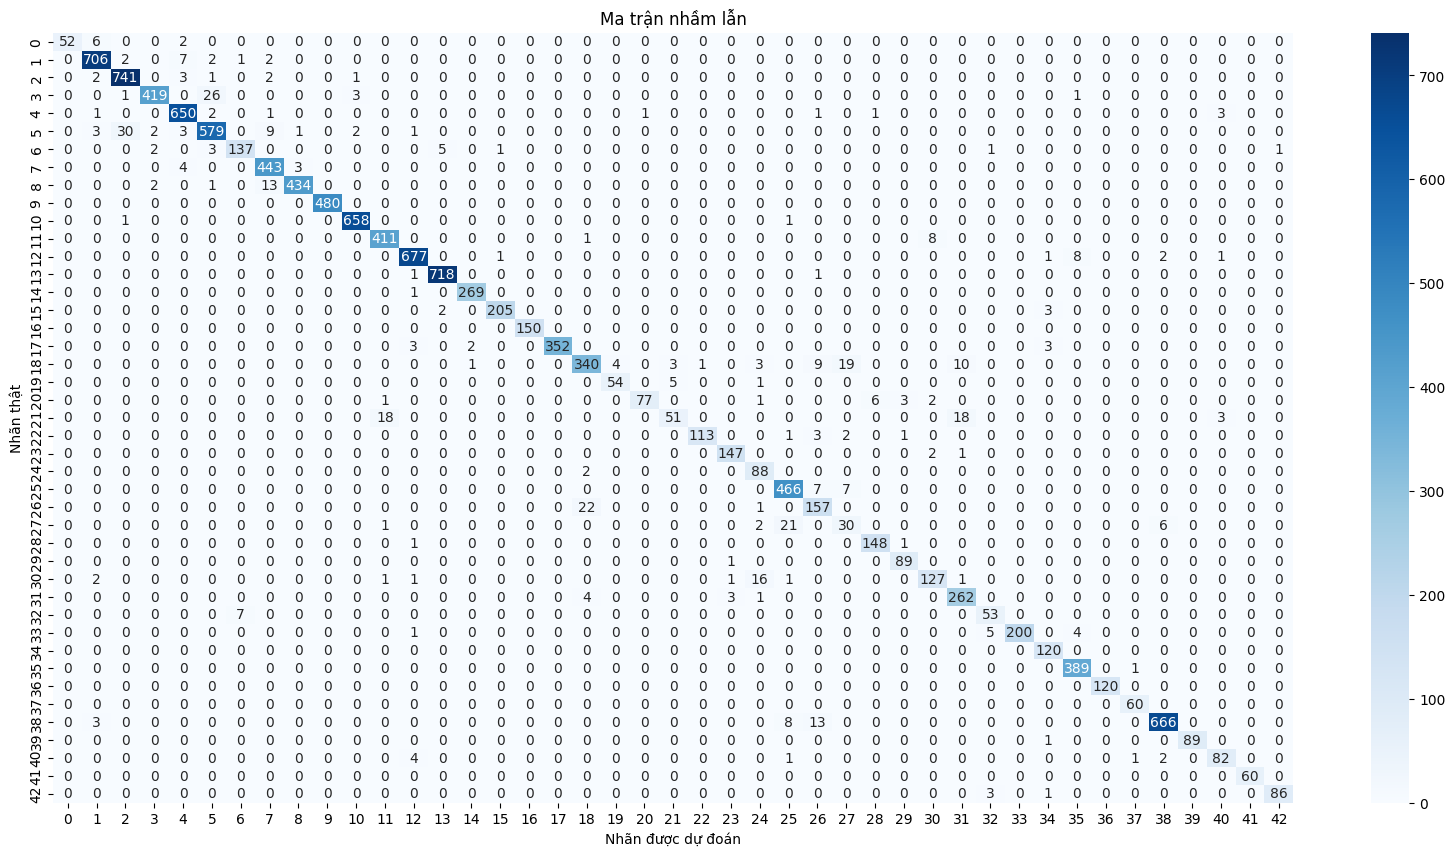

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Nhãn được dự đoán')
plt.ylabel('Nhãn thật')
plt.title('Ma trận nhầm lẫn')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])



Test Score: 0.11658883094787598
Test Accuracy: 0.9623911380767822


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/cd/model.h5')
print("✅ Mô hình đã được lưu thành công.")

NameError: name 'model' is not defined